# Ce document comprend:
    - Reseau de Neurone from scratch ( CNN)
    - CNN PyTorch
    - SVM SkLearn
    - KNN SkLearn

Dabord il faudra crée un dataset depuis les images de l'ensemble A que nous avons étiquetté manuellement et ajouter des images contenant des No_shape, c'est-à-dire une image étiquetté ayant aucune forme.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [20]:
import os, glob, math
import pandas as pd

path = os.getcwd()

img_folder_path = path + "/EnsembleA/"
csv_input_folder= path + "/csv_input/"
csv_output_folder = path + "/csv_output/"


colonne = ['label','x1','y1','x2','y2','x3','y3','x4','y4','path_img']
dataset = pd.DataFrame(columns=colonne, index=None)

for csv in glob.glob(csv_input_folder+"*.csv"):
    df = pd.read_csv(csv, header=None)
    for index, row in df.iterrows():
        
        if (row[6] == 320) and (row[7] == 240):
            #(B=X1, C=Y1, D+B=X2, C=Y2, B=X3, C+E=Y3)
            label = row[0].title()

            # print(label)
            x1 = row[1]
            y1 = row[2]
            dist_x = row[3]
            dist_y = row[4]

            x2 = x1 + dist_x
            y2 = y1

            x3 = x1
            y3 = y1 + dist_y

            x4 = x1 + dist_x
            y4 = y1 + dist_y

            nom_du_file = row[5]
            if 'Diamand' in label:
                label = label.replace('Diamand', 'Diamant')
                nom_du_file = nom_du_file.replace('Diamand', 'Diamant')
            # path_img = os.path.dirname(os.path.abspath(__file__)) + "/images/" + label[:-2] +'/'+ row[5]


            if label == "No_Shape":
                label_path = (label + 's'  ).replace('_','')
            else:
                label_path = (label[:-2] +'s'+'/'+ label ).replace('_','')

            path_img = img_folder_path + label_path + '/' + nom_du_file

            new_row = {'label':label, 'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2, 'x3':x3, 'y3':y3, 'x4':x4, 'y4':y4, 'path_img':path_img}

            dataset = dataset.append(new_row,ignore_index=True)

# Mettre les row aléatoire pour pouvoir séparer en test et train 
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Nombre de sample selon un pourcentage donnee exmepl(80:20)
nb = int(math.floor(len(dataset) * 0.2))

test_set = dataset[:nb]
train_set = dataset[nb:]

dataset.to_csv(csv_output_folder+ "all_dataset.csv", index=False)
test_set.to_csv(csv_output_folder+ "testing_dataset.csv", index=False)
train_set.to_csv(csv_output_folder+ "trainning_dataset.csv", index=False)


# CNN from scratch

In [3]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import os
from torch.utils.data.sampler import SubsetRandomSampler
import json,codecs

In [9]:
class Conv_op:
    def __init__(self, num_filters, filter_size, trainning=True):
        
        if trainning:
            self.num_filters = num_filters
            self.filter_size = filter_size
            #On normalise le filtre et on initialise le filtre avec des valeur randoms
            self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/(filter_size*filter_size)
        else:
            self.num_filters = num_filters
            self.filter_size = filter_size
            
    def set_conv_filter(self, conv_filter):
        self.conv_filter = conv_filter

    #Generator fonction    
    def image_region(self, image):
        height, width = image.shape
        self.image = image
        for j in range(height - self.filter_size + 1):
            for k in range(width - self.filter_size + 1):
                image_patch = image[j : (j + self.filter_size), k : (k + self.filter_size)]
                #Sauvegarde limage ds un buffer
                yield image_patch, j, k
    
    def foward_propagation(self,image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters))
        for image_patch, i, j in self.image_region(image):
            conv_out[i, j] = np.sum(image_patch*self.conv_filter, axis = (1,2))
        return conv_out
    
    # max_pooled est la valeur que lon recoit du max pool lors du back_prop
    def back_propagation(self, max_pooled, lr):
        params = np.zeros(self.conv_filter.shape)
        for image_patch, i,j in self.image_region(self.image):
            for k in range (self.num_filters):
                params[k] += image_patch*max_pooled[i, j, k]
                
        self.conv_filter -= lr *params
        return params

In [10]:
class Max_pool:
    def __init__(self, filter_size):
        self.filter_size = filter_size
    
    def image_region(self, img):
        new_height = img.shape[0] // self.filter_size
        new_width = img.shape[1] // self.filter_size
        self.image = img
        for i in range(new_height):
            for j in range(new_width):
                image_patch = img[(i*self.filter_size): (i*self.filter_size+self.filter_size),(j*self.filter_size):(j*self.filter_size+self.filter_size)]
                yield image_patch, i, j
                
    def foward_propagation(self, image):
        height, width, num_filters = image.shape
        output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))
        for image_patch, i, j in self.image_region(image):
            output[i,j] = np.amax(image_patch, axis=(0,1))
        return output
    
    #dl_out est la valeur du softmax lors du back_prop
    def back_propagation(self, dl_dout):
        dl_dmax = np.zeros(self.image.shape)
        for image_patch, i, j in self.image_region(self.image):
            height, width, num_filters = image_patch.shape
            max_val = np.amax(image_patch, axis=(0,1))
            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(num_filters):
                        #Si le gradient est la valeur maximum, copier le gradient
                        if image_patch[i1,j1,k1] == max_val[k1]:
                            dl_dmax[i*self.filter_size+i1, j*self.filter_size+j1, k1] = dl_dout[i,j,k1]
                            
        return dl_dmax

In [11]:
class Softmax:
    def __init__(self, input_len, nodes, trainning=True):
        if trainning:
            self.weight = np.random.randn(input_len, nodes)/input_len
            self.bias = np.zeros(nodes)
        
        
    def set_weight_and_bias(self,weight,bias):
        self.weight = weight
        self.bias = bias
        

    def foward_propagation(self, image):
        self.orig_img_shape = image.shape
        image_modified = image.flatten()
        #Utiliser dans le back_prop
        self.modified_input = image_modified
        out_val = np.dot(image_modified, self.weight) + self.bias
        self.out = out_val
        exp_out = np.exp(out_val)
        return exp_out/np.sum(exp_out, axis=0)
    
    def back_propagation(self, dl_dout, lr):
        for i, gradient in enumerate(dl_dout):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.out)
            S_total = np.sum(transformation_eq)
            
            #Gradient du total par rapport a out
            dy_dz = -transformation_eq[i]*transformation_eq / (S_total **2)
            dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i])/(S_total**2)
            
            #Gradient tu total contre les weights,biases et input
            dz_dw = self.modified_input
            dz_db = 1
            dz_d_input = self.weight
            
            #Gradient du loss avec le total
            dL_dz = gradient *dy_dz
            
            #Gradient du loss avec weights,biases et input
            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
            dL_db = dL_dz * dz_db
            dL_d_input = dz_d_input @ dL_dz
            
            #On update les poids et les biases
            self.weight -= lr *dL_dw
            self.bias -= lr * dL_db
            
            #Représente le cube qui sera envoyer au max_pool layer
            return dL_d_input.reshape(self.orig_img_shape)

In [12]:
classes = ["No_Shapes","Cercle_2","Cercle_3","Cercle_4","Cercle_5","Hexagone_2","Hexagone_3","Hexagone_4","Hexagone_5",
         "Diamand_2","Diamand_3","Diamand_4","Diamand_5","Triangle_2","Triangle_3","Triangle_4","Triangle_5"]

class ImageLoader(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        
        img_path = "C:/Users/massy/Dev/csv_builder/" + self.data.iloc[idx, 9]
        img_class =  self.data.iloc[idx,0]
        x1 = self.data.iloc[idx,1]                      
        y1 = self.data.iloc[idx,2]
        x2= self.data.iloc[idx,3]
        y2= self.data.iloc[idx,4]
        x3= self.data.iloc[idx,7]
        y3= self.data.iloc[idx,8]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255 - 0.5
        resized = cv2.resize(img, (225,225), interpolation = cv2.INTER_AREA)
        rows, cols = resized.shape
        pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3]])
        pts2 = np.float32([[0,0],[225,0],[225,225]])
        matrix = cv2.getAffineTransform(pts1,pts2)
        result = cv2.warpAffine(img, matrix, (cols, rows))
        if self.transform:
            result = self.transform(result)
              
        return result, classes.index(img_class)
        

In [21]:

# out shape = (image_size - 3 + 1) x (image_size - 3 + 1) x 8
conn = Conv_op(8, 3)
max_pool = Max_pool(2)
soft = Softmax(13*13*8,17)
classes = ["No_Shape","Cercle_2","Cercle_3","Cercle_4","Cercle_5","Hexagone_2","Hexagone_3","Hexagone_4","Hexagone_5",
         "Diamant_2","Diamant_3","Diamant_4","Diamant_5","Triangle_2","Triangle_3","Triangle_4","Triangle_5"]

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
def foward_propagation(img, label):
    out = conn.foward_propagation(img)
    out = max_pool.foward_propagation(out)
    out = soft.foward_propagation(out)
    cross_loss = -np.log(out[label])
    accuracy = 1 if np.argmax(out) == label else 0
    return out, cross_loss, accuracy

def cnn_training(image, label, lr = 0.05):
    
    out, loss, acc = foward_propagation(image, label)
    gradient = np.zeros(17)
    gradient[label] = -1/out[label]
    
    back_gradient = soft.back_propagation(gradient,lr)
    back_gradient = max_pool.back_propagation(back_gradient)
    back_gradient = conn.back_propagation(back_gradient,lr)
    return loss, acc

trainning_data = pd.read_csv(os.getcwd()+"/csv_output/trainning_dataset.csv")
testing_data = pd.read_csv(os.getcwd()+"/csv_output/testing_dataset.csv")
for epoch in range(3):
    print("Epoch %d ----->" % (epoch + 1))
    
    loss = 0
    num_correct = 0
    iterations = 0

    for i, row in trainning_data.iterrows():

        img_path = row["path_img"]
        x1 = row["x1"]                      
        y1 = row["y1"]
        x2= row["x2"]
        y2= row["y2"]
        x3= row["x4"]
        y3= row["y4"]
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255 - 0.5
            new_img = img[y1:y3,x1:x3]
            result = cv2.resize(new_img, (28,28))
        except:
            print(img_path)
       
        #pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3]])
        #pts2 = np.float32([[0,0],[rows,0],[rows,cols]])
        #matrix = cv2.getAffineTransform(pts1,pts2)
        #result = cv2.warpAffine(img, matrix, (28, 28))
        label =  row["label"]
        label = classes.index(label)
        
        if i % 100 == 0:
            print ("%d steps out of %d steps: Average Loss %.3f and Accuracy: %d%%" %(i, len(trainning_data),loss/100,num_correct))
            loss = 0
            num_correct = 0
        l1, accuracy = cnn_training(result,label)
        loss += l1
        num_correct += accuracy
        iterations += 1
        
    train_loss.append(loss/iterations)
    train_accuracy.append(100 * num_correct/len(trainning_data))

print("------------------Testing-----------------------------")
loss = 0
num_correct = 0
for i, row in testing_data.iterrows():

        img_path = row["path_img"]
        x1 = row["x1"]                      
        y1 = row["y1"]
        x2= row["x2"]
        y2= row["y2"]
        x3= row["x4"]
        y3= row["y4"]
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255 - 0.5
            new_img = img[y1:y3,x1:x3]
            result = cv2.resize(new_img, (28,28))
        except:
            print(img_path)
        
        #pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3]])
        #pts2 = np.float32([[0,0],[rows,0],[rows,cols]])
        #matrix = cv2.getAffineTransform(pts1,pts2)
        #result = cv2.warpAffine(img, matrix, (28, 28))
        label =  row["label"]
        label = classes.index(label)
        _, l1,accuracy = foward_propagation(result, label)
        loss += 1
        num_correct += accuracy

print("Testing Loss: ", loss/len(testing_data))
print("Testing Accuracy: ", (num_correct/len(testing_data))*100)


trainned_conv_filter = conn.conv_filter
trainned_soft_weights = soft.weight
trainned_soft_biases = soft.bias

pretrained_hyperparameters = {"conv_filter": trainned_conv_filter.tolist(), 
                              "soft_weight": trainned_soft_weights.tolist(),
                             "soft_bias": trainned_soft_biases.tolist()}
file_path = 'pretrained_hyperparameters.json'
json.dump(pretrained_hyperparameters, codecs.open(file_path,'w',encoding='utf-8'), separators=(',',':'),sort_keys=True,indent=4)

Epoch 1 ----->
0 steps out of 4044 steps: Average Loss 0.000 and Accuracy: 0%
100 steps out of 4044 steps: Average Loss 2.715 and Accuracy: 20%
200 steps out of 4044 steps: Average Loss 2.500 and Accuracy: 25%
300 steps out of 4044 steps: Average Loss 2.277 and Accuracy: 34%
400 steps out of 4044 steps: Average Loss 1.772 and Accuracy: 50%
500 steps out of 4044 steps: Average Loss 1.843 and Accuracy: 44%
600 steps out of 4044 steps: Average Loss 1.556 and Accuracy: 55%
700 steps out of 4044 steps: Average Loss 1.758 and Accuracy: 45%
800 steps out of 4044 steps: Average Loss 1.506 and Accuracy: 57%
900 steps out of 4044 steps: Average Loss 1.170 and Accuracy: 66%
1000 steps out of 4044 steps: Average Loss 1.079 and Accuracy: 68%
1100 steps out of 4044 steps: Average Loss 1.061 and Accuracy: 71%
1200 steps out of 4044 steps: Average Loss 1.339 and Accuracy: 65%
1300 steps out of 4044 steps: Average Loss 1.056 and Accuracy: 72%
1400 steps out of 4044 steps: Average Loss 0.806 and Accurac

------------------Testing-----------------------------
Testing Loss:  1.0
Testing Accuracy:  85.74257425742574


In [22]:
pretrained_hyperparameters = codecs.open('pretrained_hyperparameters.json','r',encoding='utf-8').read()
hyperparameters = json.loads(pretrained_hyperparameters)
pretrainned_conv_filter = hyperparameters.get("conv_filter","")
pretrainned_soft_weight = hyperparameters.get("soft_weight","")
pretrainned_soft_bias = hyperparameters.get("soft_bias","")
testing_data = pd.read_csv(os.getcwd()+"/csv_output/testing_dataset.csv")

conn = Conv_op(8, 3,trainning=False)
conn.set_conv_filter(pretrainned_conv_filter)
max_pool = Max_pool(2)
soft = Softmax(13*13*8,17,trainning=False)
soft.set_weight_and_bias(pretrainned_soft_weight,pretrainned_soft_bias)
classes = ["No_Shape","Cercle_2","Cercle_3","Cercle_4","Cercle_5","Hexagone_2","Hexagone_3","Hexagone_4","Hexagone_5",
         "Diamant_2","Diamant_3","Diamant_4","Diamant_5","Triangle_2","Triangle_3","Triangle_4","Triangle_5"]


def foward_propagation(img, label):
    out = conn.foward_propagation(img)
    out = max_pool.foward_propagation(out)
    out = soft.foward_propagation(out)
    cross_loss = -np.log(out[label])
    accuracy = 1 if np.argmax(out) == label else 0
    return out, cross_loss, accuracy

loss = 0
num_correct = 0    
for i, row in testing_data.iterrows():

        img_path = row["path_img"]
        x1 = row["x1"]                      
        y1 = row["y1"]
        x2= row["x2"]
        y2= row["y2"]
        x3= row["x4"]
        y3= row["y4"]
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255 - 0.5
            new_img = img[y1:y3,x1:x3]
            result = cv2.resize(new_img, (28,28))
        except:
            print(img_path)
        
        #pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3]])
        #pts2 = np.float32([[0,0],[rows,0],[rows,cols]])
        #matrix = cv2.getAffineTransform(pts1,pts2)
        #result = cv2.warpAffine(img, matrix, (28, 28))
        label =  row["label"]
        label = classes.index(label)
        _, l1,accuracy = foward_propagation(result, label)
        loss += 1
        num_correct += accuracy

print("Testing Loss: ", loss/len(testing_data))
print("Testing Accuracy: ", (num_correct/len(testing_data))*100)

Testing Loss:  1.0
Testing Accuracy:  85.74257425742574


# CNN avec librairie : PyTorch

In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from numpy import asarray
import cv2
import torch.nn.functional as nnf

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Grayscale image so 1 chanel
        # We want same padding so: (filter_size -1)/2 --> (3-1)/2 = 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8,kernel_size=3, stride=1, padding=1)
        # The output feature map of each of the 8 feature maps:
        # [(input_size - filter_size + 2 (padding))/stride +1] = (28 - 3 + 2(1))/1  + 1 = 28
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
         #The output_size = 28/2 = 14
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # The number of output from the last layer is 8 so we also have 8 intput channels
        # We want same padding so: (filter_size -1)/2 --> (5-1)2 = 2
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32,kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps:
        #[(input_size - filter_size + 2 (padding))/stride +1] = (14 - 5 + 2(2))/1  + 1 = 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        # Flatten 32 feature map : 7*7*32 = 1568
        self.fc1 = nn.Linear(1568, 600)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(600,17)
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        #Flatten
        out = out.view(-1, 1568)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [26]:
classes = ["No_Shape","Cercle_2","Cercle_3","Cercle_4","Cercle_5","Hexagone_2","Hexagone_3","Hexagone_4","Hexagone_5",
         "Diamant_2","Diamant_3","Diamant_4","Diamant_5","Triangle_2","Triangle_3","Triangle_4","Triangle_5"]

class ImageLoader(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data.iloc[idx, 9]
        img_path = img_path.replace("\\","/")
        img_class =  self.data.iloc[idx,0]
        x1 = self.data.iloc[idx,1]                      
        y1 = self.data.iloc[idx,2]
        x2= self.data.iloc[idx,3]
        y2= self.data.iloc[idx,4]
        x3= self.data.iloc[idx,7]
        y3= self.data.iloc[idx,8]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)/255
        new_img = img[y1:y3,x1:x3]
        result = cv2.resize(new_img, (28,28))
            
        return (result, classes.index(img_class))



Epoch 1/20, Training Loss: 2.014, Training Accuracy: 39.491, Testing Loss: 1.615, Testing Accuracy : 55.347
Epoch 2/20, Training Loss: 0.951, Training Accuracy: 74.382, Testing Loss: 0.732, Testing Accuracy : 82.970
Epoch 3/20, Training Loss: 0.580, Training Accuracy: 84.545, Testing Loss: 0.499, Testing Accuracy : 87.327
Epoch 4/20, Training Loss: 0.400, Training Accuracy: 89.886, Testing Loss: 0.401, Testing Accuracy : 89.901
Epoch 5/20, Training Loss: 0.307, Training Accuracy: 92.013, Testing Loss: 0.357, Testing Accuracy : 90.396
Epoch 6/20, Training Loss: 0.257, Training Accuracy: 93.497, Testing Loss: 0.308, Testing Accuracy : 91.683
Epoch 7/20, Training Loss: 0.209, Training Accuracy: 94.659, Testing Loss: 0.290, Testing Accuracy : 92.772
Epoch 8/20, Training Loss: 0.177, Training Accuracy: 95.425, Testing Loss: 0.269, Testing Accuracy : 93.366
Epoch 9/20, Training Loss: 0.139, Training Accuracy: 96.958, Testing Loss: 0.265, Testing Accuracy : 93.564
Epoch 10/20, Training Loss: 

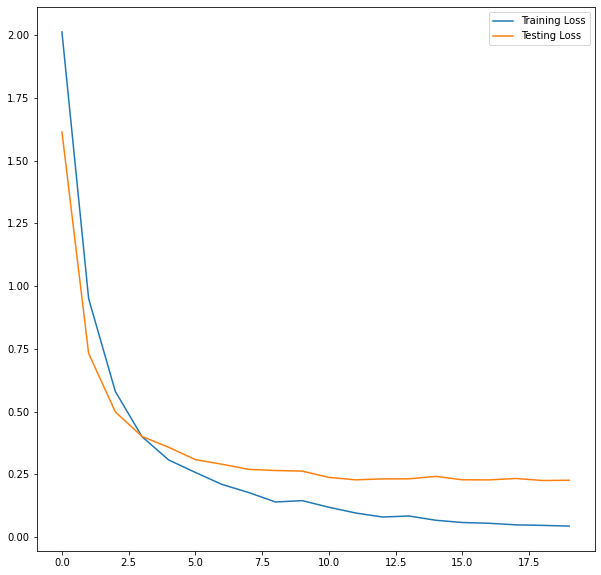

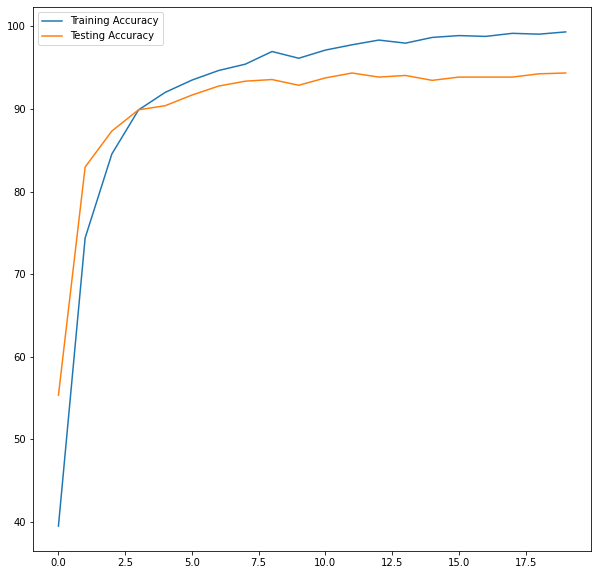

In [30]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 20
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
train_dataset = ImageLoader(os.getcwd()+"/csv_output/trainning_dataset.csv")
test_dataset = ImageLoader(os.getcwd()+"/csv_output/testing_dataset.csv")
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_laod =  torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i, (inputs,labels) in enumerate(train_load):
       
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        inputs = inputs.unsqueeze(1)
        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _,predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100 * correct/len(train_dataset))
    
    test_loss1= 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    
    for i, (inputs,labels) in enumerate(test_laod):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
         
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        test_loss1 += loss.item()
        
        
        _,predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    test_loss.append(test_loss1/iterations)
    test_accuracy.append(100 *correct/len(test_dataset))
    
    print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy : {:.3f}"
          .format(epoch+1,num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))
    
f = plt.figure(figsize= (10,10))
plt.plot(train_loss, label= 'Training Loss')
plt.plot(test_loss, label= 'Testing Loss')
plt.legend()
plt.show()

f = plt.figure(figsize= (10,10))
plt.plot(train_accuracy, label= 'Training Accuracy')
plt.plot(test_accuracy, label= 'Testing Accuracy')
plt.legend()
plt.show()

# Pour le SVM et le KNN nous aurons besoin d'un dataset different
## Creation d'un dataset depuis l'ensembleA:
On doit redimensionner les images puis transformer le tableau 2d de pixel en 1 vecteur
Puis nous alons enregistrer ces pixel(features) avec comme premiere colonne : label
    - exemple : ['cercle_2', f1,f2,f3,........fn]

In [31]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import pylab as pl
import cv2, math
import matplotlib.pyplot as plt

In [32]:
all_set = pd.read_csv(os.getcwd()+'/csv_output/all_dataset.csv')


df = pd.DataFrame(columns=None)
list_img = []

for index, r in all_set.iterrows():
    try:
        label = r['label']
        image = cv2.imread(r['path_img'],cv2.IMREAD_GRAYSCALE) / 255

        cropped_img = image[r['y1']:r['y4'],r['x1']:r['x4']]
        image = cv2.resize(cropped_img, (28,28))


        flatten_image = image.flatten()

        vector_label_pixels = np.append(label,flatten_image)
        list_img.append(vector_label_pixels)
    except:
        print(r['path_img'])
dataset = pd.DataFrame(data = list_img)
dataset.to_csv(os.getcwd()+"/csv_output/dataset_pixels.csv", index=False)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,Cercle_3,0.8501575630252101,0.8465861344537816,0.8513655462184874,0.7659663865546219,0.6898984593837535,0.7610119047619047,0.7326505602240896,0.7297093837535014,0.7282738095238095,...,0.4847163865546234,0.46785714285714436,0.4543942577030828,0.4434173669467802,0.44585084033613565,0.46964285714285886,0.4914390756302537,0.7444852941176482,0.8521533613445382,0.8144432773109244
1,No_Shape,0.7607843137254902,0.7607843137254902,0.7599439775910364,0.7599439775910364,0.7607843137254902,0.7607843137254902,0.7607843137254902,0.7607843137254902,0.7607843137254902,...,0.06734693877551032,0.0937725090036013,0.11815226090436179,0.08258303321328542,0.11956782713085264,0.31921768707483,0.7861344537815123,0.8306422569027613,0.8109893957583034,0.4587785114045581
2,Diamant_2,0.5570928371348539,0.8724289715886354,0.4869147659063625,0.48816526610644256,0.49411764705882355,0.47845138055222086,0.5120148059223689,0.46694677871148466,0.5341436574629852,...,0.5436174469787914,0.5559923969587833,0.5494997999199679,0.5333333333333333,0.5488995598239295,0.5232292917166866,0.5137254901960784,0.5324929971988797,0.5063725490196078,0.49411764705882355
3,Diamant_5,0.6777360944377752,0.6838935574229692,0.6879551820728291,0.6935224089635854,0.7085884353741497,0.7066676670668267,0.7049669867947179,0.7046218487394958,0.7042316926770709,...,0.7305672268907563,0.6893557422969188,0.710859343737495,0.6822128851540619,0.7131152460984393,0.7339385754301722,0.7342086834733894,0.712605042016807,0.6134453781512607,0.25476190476190613
4,Diamant_2,0.18319327731092436,0.09495798319327736,0.33529411764705885,0.6254901960784314,0.7588235294117647,0.7971988795518208,0.815406162464986,0.796078431372549,0.792156862745098,...,0.46302521008403363,0.4745098039215686,0.47282913165266105,0.45266106442577025,0.4470588235294118,0.4507002801120448,0.4705882352941177,0.47871148459383756,0.49131652661064434,0.4932773109243697


## Separation du dataset en Train et Test

In [33]:
dataset = pd.read_csv(os.getcwd()+'/csv_output/dataset_pixels.csv')


#Split dataset into train_set and test_set
pourcent = 0.2

nb = int(math.floor(len(dataset) * 0.2))

test_set = dataset[:nb]
train_set = dataset[nb:]

y_train = train_set.iloc[:,:1].to_numpy()
x_train = train_set.iloc[:,1:].to_numpy()

y_test = test_set.iloc[:,:1].to_numpy()
x_test = test_set.iloc[:,1:].to_numpy()




# SVM

/home/ziz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Rapport de Classification SVM SVC(gamma=0.001):
              precision    recall  f1-score   support

    Cercle_2       0.52      0.61      0.56        66
    Cercle_3       0.46      0.88      0.61        94
    Cercle_4       0.91      0.91      0.91        67
    Cercle_5       1.00      0.55      0.71        42
   Diamant_2       0.48      0.68      0.56        88
   Diamant_3       0.59      0.46      0.52        56
   Diamant_4       1.00      0.42      0.59        57
   Diamant_5       0.92      0.59      0.72        37
  Hexagone_2       0.67      0.74      0.70        73
  Hexagone_3       0.95      0.33      0.49        64
  Hexagone_4       0.97      0.67      0.79        45
  Hexagone_5       0.75      0.49      0.59        49
    No_Shape       0.64      0.97      0.77        61
  Triangle_2       0.80      0.88      0.84        90
  Triangle_3       1.00      0.62      0.76        39
  Triangle_4       0.67      0.72      0.69        47
  Triangle_5       0.93      0.37

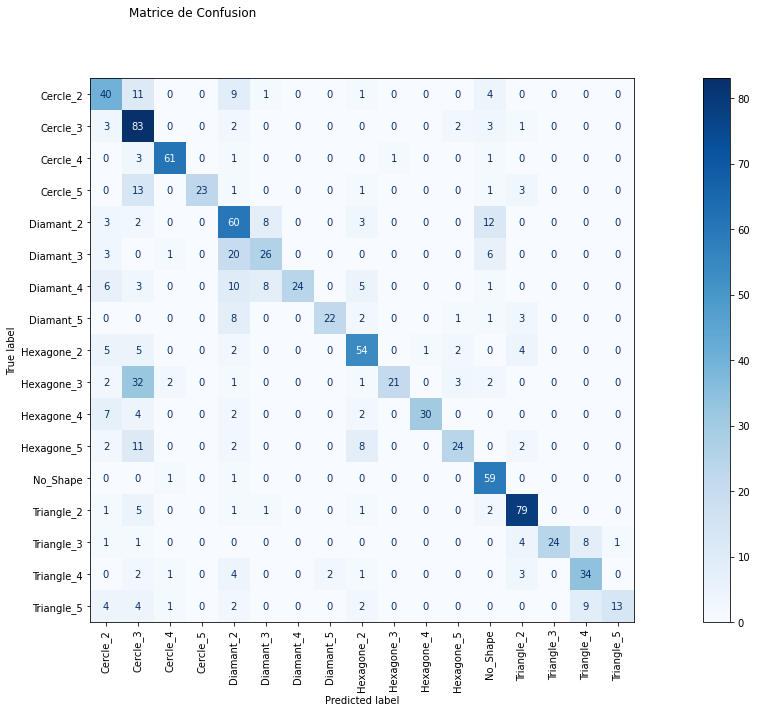

In [34]:
from sklearn import datasets, svm, metrics

# Crée un classifier
classifier = svm.SVC(gamma=0.001)
classifier.fit(x_train, y_train)

# Prediction
prediction = classifier.predict(x_test)


print("Rapport de Classification SVM %s:\n%s\n" %(classifier, metrics.classification_report(y_test, prediction)))

fig, ax = plt.subplots(figsize=(25, 10))
disp = metrics.plot_confusion_matrix(classifier, x_test, y_test, xticks_rotation = 'vertical',cmap=plt.cm.Blues, ax=ax)

disp.figure_.suptitle("Matrice de Confusion")
print("Matrice de Confusion :\n%s" % disp.confusion_matrix)

plt.xticks(rotation=90)
plt.show()


# Knn

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Rapport de Classification SVM SVC(gamma=0.001):
              precision    recall  f1-score   support

    Cercle_2       0.73      0.80      0.76        66
    Cercle_3       0.87      0.91      0.89        94
    Cercle_4       0.95      0.84      0.89        67
    Cercle_5       1.00      0.81      0.89        42
   Diamant_2       0.65      0.72      0.68        88
   Diamant_3       0.70      0.57      0.63        56
   Diamant_4       0.93      0.65      0.76        57
   Diamant_5       1.00      0.73      0.84        37
  Hexagone_2       0.81      0.90      0.86        73
  Hexagone_3       0.97      0.88      0.92        64
  Hexagone_4       0.94      0.76      0.84        45
  Hexagone_5       0.95      0.76      0.84        49
    No_Shape       0.68      1.00      0.81        61
  Triangle_2       0.78      0.92      0.85        90
  Triangle_3       0.87      0.87      0.87        39
  Triangle_4       0.80      0.91      0.85        47
  Triangle_5       0.91      0.83

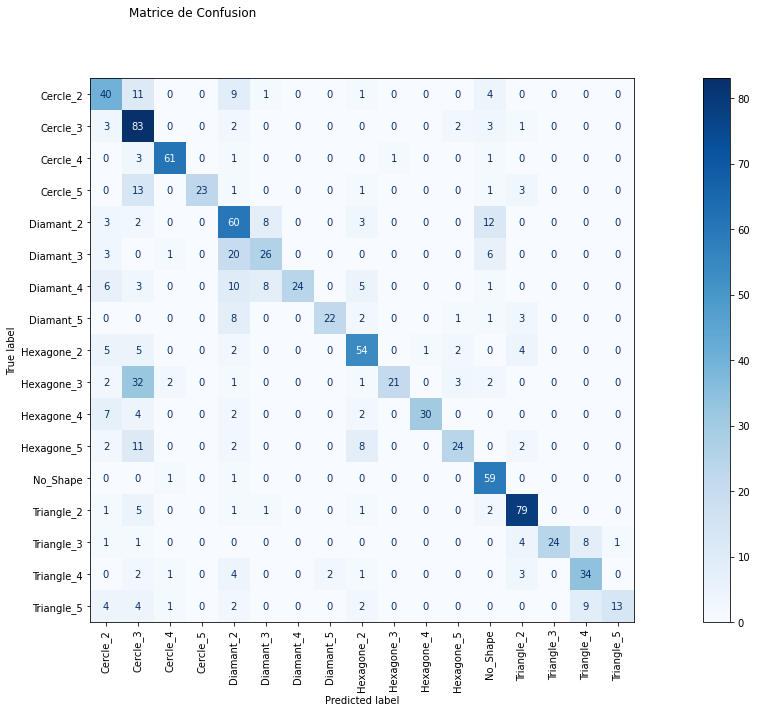

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)


print("Rapport de Classification SVM %s:\n%s\n" %(classifier, metrics.classification_report(y_test, prediction)))

fig, ax = plt.subplots(figsize=(25, 10))
disp = metrics.plot_confusion_matrix(classifier, x_test, y_test, xticks_rotation = 'vertical',cmap=plt.cm.Blues, ax=ax)
disp.figure_.suptitle("Matrice de Confusion")
print("Matrice de Confusion :\n%s" % disp.confusion_matrix)

# plt.xticks(rotation=90)
plt.show()
